### Main Notebook for visualisation 

Setup for required libraries:

In [6]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [69]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path3, sep=';',header=None)



In [70]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

Doing it for one Node as i cant get it working for more than 1 atm:

In [71]:
vel_data = df_vel.iloc[:, 1]
idle_data = df_idle.iloc[:, 1]
vuln_data = df_vuln.iloc[:, 1]
dist_data = df_dist.iloc[:, 1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna()
df.iloc[:,-1].value_counts()

1
3.0     97
2.0     96
1.0     96
4.0     95
5.0     95
        ..
59.7     1
60.7     1
66.8     1
67.8     1
18.6     1
Name: count, Length: 2924, dtype: int64

Train and test split:

In [78]:
threshold = 50

df.iloc[df.iloc[:, -1] < threshold, -1] = 0
df.iloc[df.iloc[:, -1] >= threshold, -1] = 1


dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,2].value_counts()



15033 6443


1
0.0    20456
1.0     1020
Name: count, dtype: int64

In [87]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-1]
		dataX.append(a)
		dataY.append(dataset[i + look_back, -1])
	return np.array(dataX), np.array(dataY)

look_back = 50

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainY)

[0. 0. 0. ... 0. 0. 0.]


In [88]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
trainX.shape

(14982, 50, 3)

In [89]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[-1])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
14982/14982 - 104s - loss: 0.0845 - accuracy: 0.9758 - 104s/epoch - 7ms/step
Epoch 2/10
14982/14982 - 103s - loss: 0.0258 - accuracy: 0.9943 - 103s/epoch - 7ms/step
Epoch 3/10
14982/14982 - 99s - loss: 0.0249 - accuracy: 0.9944 - 99s/epoch - 7ms/step
Epoch 4/10
14982/14982 - 92s - loss: 0.0237 - accuracy: 0.9945 - 92s/epoch - 6ms/step
Epoch 5/10
14982/14982 - 88s - loss: 0.0233 - accuracy: 0.9947 - 88s/epoch - 6ms/step
Epoch 6/10
14982/14982 - 87s - loss: 0.0235 - accuracy: 0.9947 - 87s/epoch - 6ms/step
Epoch 7/10
14982/14982 - 86s - loss: 0.0229 - accuracy: 0.9947 - 86s/epoch - 6ms/step
Epoch 8/10
14982/14982 - 87s - loss: 0.0225 - accuracy: 0.9948 - 87s/epoch - 6ms/step
Epoch 9/10
14982/14982 - 89s - loss: 0.0221 - accuracy: 0.9949 - 89s/epoch - 6ms/step
Epoch 10/10
14982/14982 - 83s - loss: 0.0221 - accuracy: 0.9947 - 83s/epoch - 6ms/step


In [93]:

trainPredict = model.predict(trainX).T[0]
testPredict = model.predict(testX).T[0]
print(trainPredict)
print(trainY)
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


200/200 [==============================] - 1s 3ms/step
[1.3596215e-04 1.3633280e-04 1.3271644e-04 ... 5.7808054e-05 6.8840614e-05
 7.7080142e-05]
[0. 0. 0. ... 0. 0. 0.]
Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


In [94]:
from sklearn.metrics import accuracy_score, f1_score

# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.5  # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)
print(trainPredict_binary)
print(trainY)

# Compute accuracy and F1 score
train_accuracy = accuracy_score(trainY, trainPredict_binary)
test_accuracy = accuracy_score(testY, testPredict_binary)

train_f1_score = f1_score(trainY, trainPredict_binary)
test_f1_score = f1_score(testY, testPredict_binary)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

print('Train F1 Score:', train_f1_score)
print('Test F1 Score:', test_f1_score)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
Train Accuracy: 0.9947937525030036
Test Accuracy: 0.9946808510638298
Train F1 Score: 0.9452247191011236
Test F1 Score: 0.9433333333333332


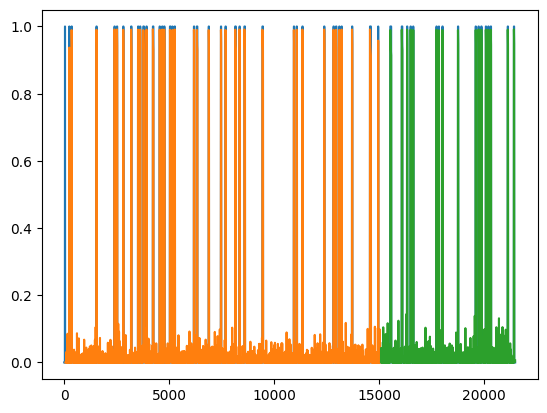

In [95]:
import matplotlib.pyplot as plt

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset[:,2])-1] = testPredict
# plot baseline and predictions
plt.plot(dataset[:,2])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()